In [1]:
# !pip install codeinterpreterapi

In [2]:
# !pip install -U "langchain<0.0.233"

In [1]:
from dotenv import find_dotenv,load_dotenv
load_dotenv(find_dotenv())

True

In [ ]:
top_k = 10000
user_input = \
    '2010年以降のレシピのうち、カロリーが高い順に100個のレシピのカロリーの散布図を書いてください。'

In [3]:
from codeboxapi import CodeBox
codebox = CodeBox()
await codebox.astart()

Status(started)

In [4]:
from codeboxapi.schema import CodeBoxOutput  # type: ignore
code = 'print("test")'
output: CodeBoxOutput = await codebox.arun(code)
print(output.content)

test



In [6]:
import os,openai,json
from dotenv import find_dotenv,load_dotenv
load_dotenv(find_dotenv())

openai.api_key = os.environ['OPENAI_API_KEY']
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import HumanMessage

from opensearchpy import OpenSearch

In [7]:
SERVICE_URI = 'localhost:9200'
INDEX_NAME = 'epicurious-recipes'
os_client = OpenSearch(hosts=SERVICE_URI, ssl_enable=True)

In [8]:
mapping_data = os_client.indices.get_mapping(INDEX_NAME)
mappings = mapping_data[INDEX_NAME]['mappings']
# print(json.dumps(mappings,indent=2))

In [9]:
DSL_TEMPLATE = """\
Given an input question, create a syntactically correct Elasticsearch query to run. \
Unless the user specifies in their question a specific number of examples they wish to obtain, \
always limit your query to at most {top_k} results. \
You can order the results by a relevant column to return the most interesting examples in the database.

Unless told to do not query for all the columns from a specific index, \
only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the mapping description. \
Be careful to not query for columns that do not exist. Also, pay attention to which column is in which index. \
Return the query as valid json.

Use the following format:

Question: Question here
ESQuery: Elasticsearch Query formatted as json

Mapping: {mapping}

Question: {input}
ESQuery:
"""

In [10]:
def get_os_dsl(query,k):
    prompt = DSL_TEMPLATE.format(
        top_k=k,
        mapping=json.dumps(mappings,indent=2),
        input=query
    )
    chat = ChatOpenAI()
    messages = [HumanMessage(content=prompt)]
    response = chat(messages)
    # print(response.content)
    return response.content

In [11]:
query = get_os_dsl(user_input,top_k)
# print(dsl)

In [32]:
result = os_client.search(index=INDEX_NAME,body=json.loads(query))
# print(json.dumps(res,indent=2))

In [27]:
template = '''\
## Input
{user_input}
## Query
{query}
## Instruction
[Input]に対して、OpenSearchで[Query]を入力し検索を行い、検索結果をresultに入力しました。
resultを用いて[Input]に対する回答を得るためのPythonコードを書いてください。
resultは入力済みの状態から開始してください。
## Output Format
```python
[[code here]]
```
'''

In [28]:
prompt = template.format(
    user_input=user_input,query=query
)

In [29]:
print(prompt)

## Input
2010年以降のレシピのうち、カロリーが高い順に100個のレシピのカロリーの散布図を書いてください。
## Query
{
  "size": 100,
  "query": {
    "range": {
      "date": {
        "gte": "2010-01-01"
      }
    }
  },
  "sort": [
    {
      "calories": {
        "order": "desc"
      }
    }
  ],
  "aggs": {
    "calories_histogram": {
      "histogram": {
        "field": "calories",
        "interval": 100
      }
    }
  }
}
## Instruction
[Input]に対して、OpenSearchで[Query]を入力し検索を行い、検索結果をresultに入力しました。
resultを用いて[Input]に対する回答を得るためのPythonコードを書いてください。
resultは入力済みの状態から開始してください。
## Output Format
```python
[[code here]]
```



In [30]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import HumanMessage
chat = ChatOpenAI(temperature=0.)
messages = [HumanMessage(content=prompt)]
response = chat(messages)

In [33]:
print(response.content)

import matplotlib.pyplot as plt

calories = []
for hit in result['hits']['hits']:
    calories.append(hit['_source']['calories'])

plt.scatter(range(1, 101), calories)
plt.xlabel('Rank')
plt.ylabel('Calories')
plt.title('Calories of Top 100 Recipes (2010 and later)')
plt.show()


In [35]:
# import matplotlib.pyplot as plt

# calories = []
# for hit in result['hits']['hits']:
#     calories.append(hit['_source']['calories'])

# plt.scatter(range(1, 101), calories)
# plt.xlabel('Rank')
# plt.ylabel('Calories')
# plt.title('Calories of Top 100 Recipes (2010 and later)')
# plt.show()

In [41]:
print(f'response = {json.dumps({"result":None})}')

response = {"result": null}


In [42]:
print(json.dumps(result)[:200])

{"took": 10, "timed_out": false, "_shards": {"total": 1, "successful": 1, "skipped": 0, "failed": 0}, "hits": {"total": {"value": 3948, "relation": "eq"}, "max_score": null, "hits": [{"_index": "epicu


In [66]:
code = f'result = {json.dumps(result).replace("false","False").replace("null","None")}\n\n'+response.content

In [67]:
print(code[:400])
print()
print(code[-400:])

result = {"took": 10, "timed_out": False, "_shards": {"total": 1, "successful": 1, "skipped": 0, "failed": 0}, "hits": {"total": {"value": 3948, "relation": "eq"}, "max_score": None, "hits": [{"_index": "epicurious-recipes", "_id": "Od0xdokBfefTV2V6DEJk", "_score": None, "_source": {"directions": ["Mix garlic, oil, curry powder, 1 cup yogurt, 2 tsp. salt, and 1/4 cup water in a large bowl. Working

doc_count": 0}, {"key": 12000.0, "doc_count": 0}, {"key": 12100.0, "doc_count": 0}, {"key": 12200.0, "doc_count": 1}]}}}

import matplotlib.pyplot as plt

calories = []
for hit in result['hits']['hits']:
    calories.append(hit['_source']['calories'])

plt.scatter(range(1, 101), calories)
plt.xlabel('Rank')
plt.ylabel('Calories')
plt.title('Calories of Top 100 Recipes (2010 and later)')
plt.show()


In [68]:
import uuid, base64, re
from io import BytesIO

In [56]:
import asyncio
from pydantic import BaseModel
class File(BaseModel):
    name: str
    content: bytes

    @classmethod
    def from_path(cls, path: str):
        with open(path, "rb") as f:
            path = path.split("/")[-1]
            return cls(name=path, content=f.read())

    @classmethod
    async def afrom_path(cls, path: str):
        return await asyncio.to_thread(cls.from_path, path)

    @classmethod
    def from_url(cls, url: str):
        import requests  # type: ignore

        r = requests.get(url)
        return cls(name=url.split("/")[-1], content=r.content)

    @classmethod
    async def afrom_url(cls, url: str):
        import aiohttp

        async with aiohttp.ClientSession() as session:
            async with session.get(url) as r:
                return cls(name=url.split("/")[-1], content=await r.read())

    def save(self, path: str):
        with open(path, "wb") as f:
            f.write(self.content)

    async def asave(self, path: str):
        await asyncio.to_thread(self.save, path)

    def show_image(self):
        try:
            from PIL import Image  # type: ignore
        except ImportError:
            print(
                "Please install it with `pip install codeinterpreterapi[image_support]` to display images."
            )
            exit(1)

        from io import BytesIO

        img_io = BytesIO(self.content)
        img = Image.open(img_io)

        # Convert image to RGB if it's not
        if img.mode not in ('RGB', 'L'):  # L is for greyscale images
            img = img.convert('RGB')

        # Display the image
        try:
            # Try to get the IPython shell if available.
            shell = get_ipython().__class__.__name__  # type: ignore

            # If the shell is ZMQInteractiveShell, it means we're in a Jupyter notebook or similar.
            if shell == 'ZMQInteractiveShell':
                from IPython.display import display
                display(img)
            else:
                # We're not in a Jupyter notebook.
                img.show()
        except NameError:
            # We're probably not in an IPython environment, use PIL's show.
            img.show()



    def __str__(self):
        return self.name

    def __repr__(self):
        return f"File(name={self.name})"

In [70]:
output: CodeBoxOutput = await codebox.arun(code)
output_files = []
if output.type == "image/png":
    filename = f"image-{uuid.uuid4()}.png"
    file_buffer = BytesIO(base64.b64decode(output.content))
    file_buffer.name = filename
    output_files.append(File(name=filename, content=file_buffer.read()))
# print(output.content)

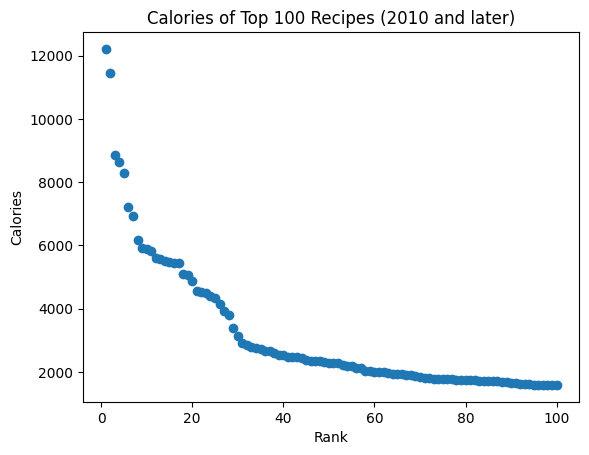

In [71]:
for f in output_files:
    f.show_image()

In [7]:
# from codeinterpreterapi import CodeInterpreterSession
# import langchain; langchain.debug=True
# import os
# async with CodeInterpreterSession(openai_api_key=os.environ['OPENAI_API_KEY'],model="gpt-3.5-turbo") as session:
#     response = await session.generate_response(
#         "Plot a sin wave and show it to me."
#     )

#     print("AI: ", response.content)
#     for file in response.files:
#         file.show_image()

In [8]:
# from codeinterpreterapi import CodeInterpreterSession
# import langchain; langchain.debug=True
# import openai; openai.api_key = os.environ['OPENAI_API_KEY']
# session = CodeInterpreterSession(openai_api_key="openai-api-key", model="gpt-3.5-turbo-0613")
# await session.astart()
# output = await session.generate_response(
#     "Plot the Tesla stock for 2023 YTD",
#     detailed_error = True
# )

# print("AI: ", output.content)
# for file in output.files:
#     file.show_image()

# await session.astop()

In [ ]:
await codebox.astop()